## Set up directory

In [1]:
%cd /Users/ianleefmans/Desktop/Insight/Project/Re-Identifying_Persistent_Skin_Conditions/skinConditionDetect


/Users/ianleefmans/Desktop/Insight/Project/Re-Identifying_Persistent_Skin_Conditions/skinConditionDetect


# Example using custom datahelper 

In [2]:
# import packages
%matplotlib inline
#from datahelper import CreateDataset
from datahelper2 import CreateDataset, my_collate2
from facealign import FaceAlign, CalculateMatches
from run_match import GeoMatch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import os
import torchvision
#from model import STN
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import argparse
import dlib
import cv2

In [6]:
# Create paths
pickle_path2 = "/Users/ianleefmans/Desktop/Insight/Project/Re-Identifying_Persistent_Skin_Conditions/skinConditionDetect/pickle/simple_train_dict.pkl"
pickle_path = "/Users/ianleefmans/Desktop/Insight/Project/Re-Identifying_Persistent_Skin_Conditions/skinConditionDetect/pickle/train_annotation_dict.pkl"
data_directory = "/Users/ianleefmans/Desktop/Insight/Project/Data"

# Create dataset
dataset = CreateDataset(pickle_path2, data_directory, local=True, geometric=True, transform = torchvision.transforms.ToTensor())
def my_collate3(batch):
    image0 = [item[0] for item in batch]
    image1 = [item[1] for item in batch]
    annotation0 = [item[2] for item in batch]
    annotation1 = [item[3] for item in batch]
    landmark0 = [item[4] for item in batch]
    landmark1 = [item[5] for item in batch]
    #target = torch.LongTensor(target)
    return image0, image1, annotation0, annotation1, landmark0, landmark1

def my_collate(batch):
    image = [item[0] for item in batch]
    image = torch.stack(image)
    annotation = [item[1] for item in batch]
    #target = torch.LongTensor(target)
    return image, annotation


train_loader = DataLoader(dataset=dataset, batch_size=1, num_workers=0, shuffle=True, collate_fn=my_collate3)
sample = iter(train_loader).next()


In [77]:
predictor = 'shape_predictor_68_face_landmarks.dat'
sample1 = (sample[0], sample[2])
sample2 = (sample[1], sample[3])
fa1 = FaceAlign(sample1, predictor)
fa2 = FaceAlign(sample2, predictor)

image1, boxes1 = fa1.forward()
image2, boxes2 = fa2.forward()

In [78]:
box1_list = []
matched_boxes = {}
for i in range(len(boxes1)):
    for j in range(len(boxes2)):
        ca = CalculateMatches(image1, image2, boxes1[i], boxes2[j])
        IoU = ca.evaluate()
        if IoU>0:
            if i in box1_list:
                if IoU > matched_boxes[i][0]:
                    matched_boxes[i] = (IoU, j)
            else:
                matched_boxes[i] = (IoU, j)
                box1_list.append(i)

In [79]:
matched_boxes

{10: (0.46981529688855833, 0), 11: (0.743939263221465, 1)}

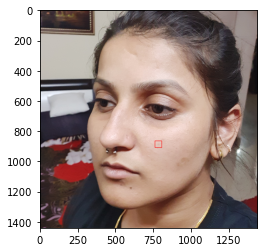

In [113]:
path1 = '/Users/ianleefmans/Desktop/Insight/Project/Data/images/cam2_c1b091a30a5f09b1_abfafa_front_280519_1717283.jpg'
path2 = '/Users/ianleefmans/Desktop/Insight/Project/Data/images/cam2_c1b091a30a5f09b1_abfafa_front_280519_1718016.jpg'
path3 = '/Users/ianleefmans/Desktop/Insight/Project/Data/images/cam2_c1b091a30a5f09b1_abfafa_front_280519_1718192.jpg'
path4 = '/Users/ianleefmans/Desktop/Insight/Project/Data/images/cam2_c1b091a30a5f09b1_abfafa_front_280519_1731196.jpg'

image1 = cv2.imread(path1)
image2 = cv2.imread(path2)
image3 = cv2.imread(path3)
image4 = cv2.imread(path4)

cv2.rectangle(image1, (759, 864), (804, 908),(0,0,255) , 2)
cv2.rectangle(image2, (989, 709), (1042, 758),(0,0,255) , 2)
cv2.rectangle(image3, (691, 727), (744, 779),(0,0,255) , 2)

plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.show()


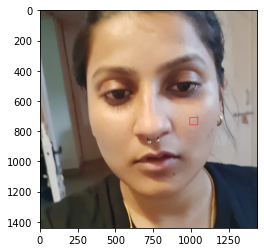

In [114]:
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()

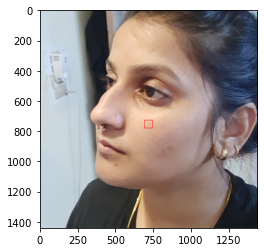

In [115]:
plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
plt.show()

### IANet (testing forward)

In [3]:
from model import STN, Encoder, IANet

In [7]:
x = torch.rand(4,3, 256, 256)

ian_net = IANet()
y, z = ian_net(x)

print(y.size(), z.size())


torch.Size([4, 3, 256, 256]) torch.Size([4, 20, 61, 61])


### Workspace for working with annotation jsons

In [ ]:
image = sample[0]
annotation = sample[1]

In [30]:
import pandas as pd
data_path = "/Users/ianleefmans/Desktop/Insight/Project/Data/followup_data/"

test_json = 'user_000000000000.json'

df = pd.read_json(data_path+test_json)

test_annotation= df.iloc[3].image_details

### Create Dictionary Mapping Index to Entry in Json File  
- save to a pickle file

In [99]:
from tqdm import tqdm
import os
import pandas as pd
import pickle
annotation_dict = {}
count = 0 
tot_count=0
for filename in tqdm(os.listdir("/Users/ianleefmans/Desktop/Insight/Project/Data/followup_data/")):
    try:
        df = pd.read_json("/Users/ianleefmans/Desktop/Insight/Project/Data/followup_data/"+filename)
        df = df.loc[(df.image_details.notnull()) & (df.image_path.notnull()),:]
        for i in list(df.index.values):
            try:
                df.iloc[i].image_details['annotation'] !=None
                df.iloc[i]['image_details']['annotation'][0]
                ok = False
                for j in df.iloc[i].image_details['annotation']:
                    if (j['condition']=='Detected') and ('bounding_boxes' in j.keys()):
                        if len(j['bounding_boxes'])>0:
                            ok = True
                if ok ==False:
                    a = 2/0
                    
                annotation_dict[count] = (filename, i)
                
                count+=1
                
                    
            except:
                print
            finally:
                pass
            
    except:
        pass
    finally:
        pass
with open("annotation_dict.pkl", 'wb') as handle:
    pickle.dump(annotation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 17293/17293 [07:27<00:00, 38.61it/s]


In [65]:
# open pickle
with open("pickle/annotation_dict.pkl", 'rb') as handle:
    dictionary = pickle.load(handle)
# open list of bad json entries
with open("pickle/bad_json_entry.pkl", 'rb') as handle:
    bad_json = pickle.load(handle)

In [ ]:
# Remove bad json entries form dictionary
for i in bad_json:
    dictionary.pop(i)

newdictionary = {}
count= 0
for i in dictionary:
    newdictionary[count]=dictionary[i]
    count+=1

In [ ]:
# re-pickle dictionary
with open("annotation_dict.pkl", 'wb') as handle:
    pickle.dump(newdictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [44]:
len(dictionary) # dictionary length after removing 467 bad json

232333

In [9]:
len(dictionary) # dictionary length after removing 11 bad json

232800

In [79]:
len(dictionary) # dictionary length before removing 11 bad json


232811

In [19]:
len(dictionary)

232333

### Create Train, Val, and Test splits on Dictionary

In [45]:
train_dictionary = {}
val_dictionary = {}
test_dictionary = {}
count1 = 0
count2 = 0
for i in tqdm(dictionary):
    if i<162632:
        train_dictionary[i] = dictionary[i]
    elif i<197483:
        val_dictionary[count1] = dictionary[i]
        count1+=1
    else:
        test_dictionary[count2] = dictionary[i]
        count2+=1

100%|██████████| 232333/232333 [00:00<00:00, 517815.67it/s]


In [46]:
#pickle train dictionary
with open("train_annotation_dict.pkl", 'wb') as handle:
    pickle.dump(train_dictionary, handle)

In [47]:
#pickle val_dictionary
with open("val_annotation_dict.pkl", 'wb') as handle:
    pickle.dump(val_dictionary, handle)

In [48]:
# pickle test_dictionary
with open("test_annotation_dict.pkl", 'wb') as handle:
    pickle.dump(test_dictionary, handle)

### Create dictionary of image and annotation pairs (for train test and val splits)

In [66]:
with open("pickle/train_annotation_dict.pkl", 'rb') as handle:
    dictionary = pickle.load(handle)

In [76]:
count = 0
simple_train_dict = {}
for i in dictionary:
    if i!=0:
        if dictionary[i][0]==dictionary[i-1][0]:
            simple_train_dict[count] = (dictionary[i-1], dictionary[i])
            count+=1
        else:
            pass
    else:
        pass

In [ ]:
with open("pickle/simple_train_dict.pkl", 'wb') as handle:
    pickle.dump(simple_train_dict, handle)

In [79]:
with open("pickle/val_annotation_dict.pkl", 'rb') as handle:
    dictionary = pickle.load(handle)

In [82]:
count = 0
simple_val_dict = {}
for i in dictionary:
    if i!=0:
        if dictionary[i][0]==dictionary[i-1][0]:
            simple_val_dict[count] = (dictionary[i-1], dictionary[i])
            count+=1
        else:
            pass
    else:
        pass

In [85]:
with open("pickle/simple_val_dict.pkl", 'wb') as handle:
    pickle.dump(simple_val_dict, handle)

In [86]:
with open("pickle/test_annotation_dict.pkl", 'rb') as handle:
    dictionary = pickle.load(handle)

In [87]:
count = 0
simple_test_dict = {}
for i in dictionary:
    if i!=0:
        if dictionary[i][0]==dictionary[i-1][0]:
            simple_test_dict[count] = (dictionary[i-1], dictionary[i])
            count+=1
        else:
            pass
    else:
        pass

In [92]:
with open("pickle/simple_test_dict.pkl", 'wb') as handle:
    pickle.dump(simple_test_dict, handle)

In [15]:
with open("pickle/simple_train_dict.pkl", 'rb') as handle:
    dictionary = pickle.load(handle)